In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from pathlib import Path
from tqdm import tqdm
import json
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from brats21 import utils as bu
from brats21.evaluation import FoldDataGenerator, PredictionGenerator
from brats21 import evaluation as valid

# Read dataframe(s)

In [3]:
unet_base_path = Path('/sc-scratch/sc-scratch-gbm-radiomics/task1_evaluation/output/nnUNetTrainerV2BraTSRegions/')
segnet_base_path = Path('/sc-scratch/sc-scratch-gbm-radiomics/task1_evaluation/output/nnUNetTrainerV2BraTSSegnet/')

In [4]:
def read_all_performance_files(base_path):
    base_path = Path(base_path)
    
    dfs = []
    for path in base_path.rglob("performance.csv"):
        df = pd.read_csv(path, index_col=0)
        dfs.append(df)
    
    return pd.concat(dfs, axis=0, ignore_index=True)

In [5]:
unet_df = read_all_performance_files(unet_base_path)
unet_df["Model"] = "UNet"

In [6]:
segnet_df = read_all_performance_files(segnet_base_path)
segnet_df["Model"] = "SegNet"

In [7]:
df = pd.concat([unet_df, segnet_df])

In [8]:
df

,id,hd_Edema,hd_Necrotic,hd_Enhancing,hd95_Edema,hd95_Necrotic,hd95_Enhancing,dc_Edema,dc_Necrotic,dc_Enhancing,sensitivity_Edema,sensitivity_Necrotic,sensitivity_Enhancing,specificity_Edema,specificity_Necrotic,specificity_Enhancing,Model
0,1031,3.162278,8.366600,10.862780,1.000000,4.582576,1.000000,0.973736,0.868293,0.982360,0.960667,0.931937,0.983938,0.999964,0.999995,0.999993,UNet
1,838,15.394804,15.684387,15.033296,5.385165,3.000000,1.000000,0.830048,0.925770,0.929161,0.772695,0.930469,0.912668,0.998976,0.999936,0.999890,UNet
2,128,14.352700,9.899495,13.038405,1.414214,4.242641,2.000000,0.951617,0.736519,0.930315,0.988562,0.789947,0.888480,0.999122,0.999819,0.999902,UNet
3,1087,11.445523,18.357560,3.162278,1.732051,5.000000,1.000000,0.934468,0.891514,0.956542,0.889196,0.903023,0.981566,0.999861,0.999956,0.999901,UNet
4,241,4.242641,10.630146,4.242641,1.000000,7.575876,1.000000,0.967451,0.558140,0.976323,0.968985,0.538462,0.973727,0.999857,0.999993,0.999985,UNet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1246,1073,13.564660,11.445523,4.898979,1.000000,2.449490,1.414214,0.967844,0.925430,0.958579,0.972032,0.899708,0.990475,0.999648,0.999974,0.999799,SegNet
1247,380,4.358899,NaN,2.236068,1.000000,NaN,1.000000,0.966979,0.000000,0.903003,0.972877,0.000000,0.931911,0.999963,0.999996,0.999985,SegNet
1248,686,13.379088,7.874008,6.708204,1.000000,2.449490,1.414214,0.964649,0.869241,0.916017,0.958311,0.783209,0.973684,0.999431,0.999941,0.999096,SegNet
1249,1261,13.601471,9.486833,7.549834,2.449490,4.954541,1.000000,0.830889,0.832972,0.854527,0.862265,0.745789,0.861906,0.999302,0.999900,0.999753,SegNet


## Transform wide to to long format

In [9]:
df = df.melt(id_vars=["id", "Model"])
df[["Metric", "Class"]] = df.variable.str.split("_", expand=True)
df.drop("variable", axis=1, inplace=True)

In [10]:
# Save long df
df.to_csv("/sc-scratch/sc-scratch-gbm-radiomics/task1_evaluation/performance.csv")

## Performance boxplot

In [11]:
sns.set_style("whitegrid")
sns.set_context("talk")

In [12]:
METRIC_TRANSLATION = {
    "hd": "Hausdorff",
    "hd95": "Hausdorff 95% CI",
    "sensitivity": "Sensitivity",
    "specificity": "Specificity",
    "dc": "Dice Coefficient"
}

In [13]:
def simple_boxplot(df, metric, translation={}):
    plt.subplots(figsize=(7, 6))
    sns.boxplot(data=df[df.Metric == metric], x="Model", y="value", hue="Class", whis=1.75, width=0.8)

    plt.title(f"{translation.get(metric, metric)}")
    sns.despine()
    plt.ylabel("")
    plt.legend(title="Class", bbox_to_anchor=(1.01, 0.99), loc=2, borderaxespad=0.)
    plt.show()

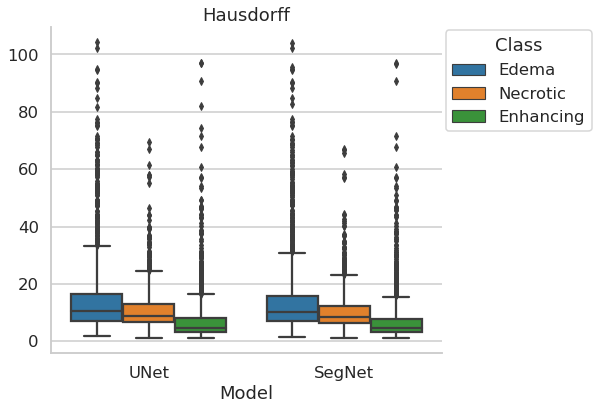

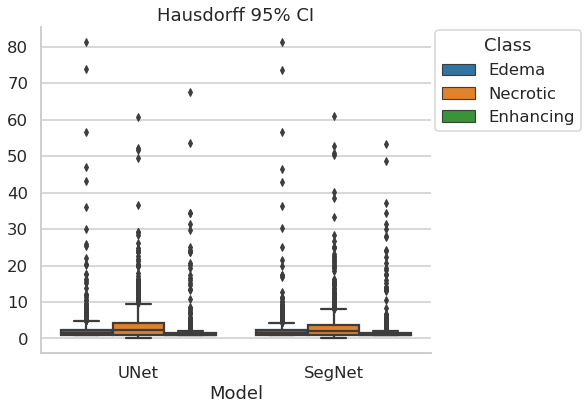

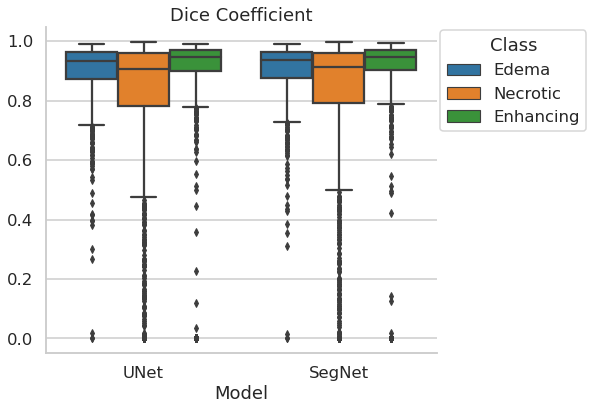

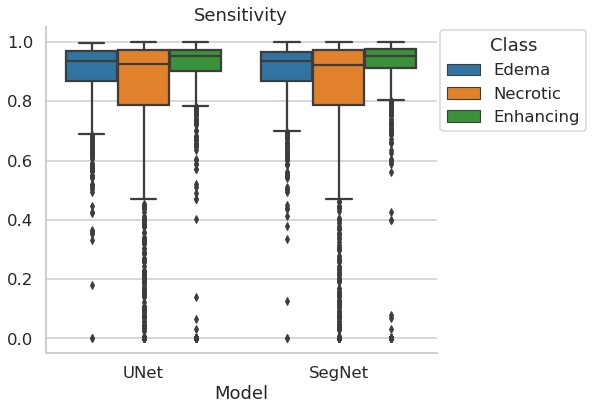

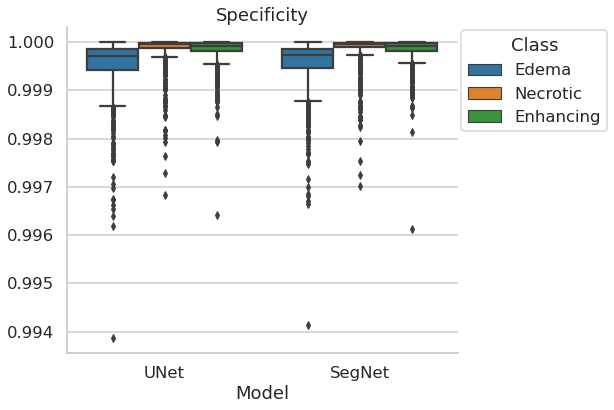

In [14]:
for metric in df.Metric.unique():
    simple_boxplot(df, metric, translation=METRIC_TRANSLATION)